In [1]:
import pandas as pd
import numpy as np
import os
import re
import emoji
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from collections import defaultdict
import nltk

nltk.download('stopwords')
from nltk.corpus import stopwords

sns.set()
STOP_WORDS = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to
[nltk_data]     /home/datalore/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
TWEET_DIR = '/data/workspace_files/Top 100 Tweets'
OUTPUT_DIR = '/data/workspace_files/Twitter Datasets'

### Twitter Dataset Compilation - Top 100

This notebook contains our compilation of the Top 100 Twitter dataset. In the **RoBERTa Sentiment Scoring** notebook, we predict sentiment scores for each tweet included in this dataset. This notebook also includes a comprehensive EDA for the tweets obtained and a word cloud of illustrating the most frequently occuring words in the dataset.

First, we load the data.

In [3]:
tweet_files = os.listdir(TWEET_DIR)
print('Directory contains {} files'.format(len(tweet_files)))

Directory contains 100 files


In [4]:
dtypes = {
    'id': str,
    'author_id': str
}
data = []

for file in tweet_files:
    try:
        df = pd.read_csv(os.path.join(TWEET_DIR, file),
                         dtype=dtypes, index_col=0, lineterminator='\n')
        df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')
    except KeyError:
        print('Problem with file: {}'.format(file))
        continue

    # drop records where the date is NaT
    df.dropna(subset=['created_at'], inplace=True)

    # drop the meta data columns as they are values as of the date pulled
    # not the date of the text
    df = df.loc[:, ['id', 'author_id', 'created_at', 'text']]
    
    data.append(df)

data = pd.concat(data, axis=0, ignore_index=True)

Next, we apply Twitter specific preprocessing so that the tweets can be fed to the RoBERTa model. See the `clean_text` function below for details on all the steps.

In [5]:
def clean_text(text, demojize=True):
    """
    Data cleaning for Twitter RoBERTa model:
    https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment
    Most text preprocessing is handled by the pretrained models'
    tokenize function, so we just do Twitter specific parsing here.
    """
    # remove new lines
    text = text.replace('\n', ' ')
    text = text.replace('\r', ' ')

    # identify retweets and parse out the retweet start
    if text.startswith('RT @'):
        try:
            text = re.findall('RT \@\S+ (.+)', text, flags=re.DOTALL)[0]
        except IndexError:
            # could not parse the retweet
            # currently only one of these so, we don't print the warning
            # print('Could not parse potential retweet: {}'.format(text))
            pass

    # remove all # symbols as they represent hashtags which shouldn't 
    # have any predictive power
    text = re.sub('#', ' ', text)

    # there are a lot of different emojis, well over 150
    # rather than add emojis as separate tokens for the model,
    # we can replace the emoji with its descriptive text, which 
    # should already be a token in any pretrained model(s)
    if demojize:
        text = emoji.demojize(text, delimiters=(' ', ' '))

    # quite a few tweets have links to external content; e.g., https://t.co/AVDxyTcSb9
    # these also shouldn't have any predictive power, so we replace them
    # with 'http' so that 'http' can be added as a special token
    # for a pretrained model
    # http is used in the pre-trained Twitter RoBERTa model
    text = re.sub('https://\S+\s*', ' http ', text)

    # many tweets include Twitter handles (e.g., other Twitter accounts)
    # we replace these with '@user' so that '@user' can be added as 
    # a special token for a pretrained model
    # @user is used in the pre-trained Twitter RoBERTa model
    text = re.sub('@[A-Za-z0-9_]+', ' @user ', text)

    # replace multiple sequential instances of '@user' with a single
    # '@user' token
    # there are a lot of tweets with 3+ handles in a row and the number of 
    # handles probably isn't that informative
    text = re.sub('(\s*\@user\s*){2,}', ' @user ', text)

    # replace multiple spaces with single spaces
    text = text.replace('\s+', ' ')

    return text

In [6]:
data['clean_text'] = data['text'].map(clean_text)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853392 entries, 0 to 853391
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id          853392 non-null  object        
 1   author_id   853392 non-null  object        
 2   created_at  853392 non-null  datetime64[ns]
 3   text        853392 non-null  object        
 4   clean_text  853392 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 32.6+ MB


In [8]:
data.head(10)

,id,author_id,created_at,text,clean_text
0,1421578024630333443,14182218,2021-07-31 21:06:27,The whole thread is very much worth a read (an...,The whole thread is very much worth a read (an...
1,1421255297427984384,14182218,2021-07-30 23:44:03,@NeerajKA @crypt0e I don’t know if malicious i...,"@user I don’t know if malicious is the word, ..."
2,1421254480260222979,14182218,2021-07-30 23:40:48,@zooko comes online and my feed is all about @...,@user comes online and my feed is all about ...
3,1421248686332518406,14182218,2021-07-30 23:17:47,Social media influencers can use Zemo as a pro...,Social media influencers can use Zemo as a pro...
4,1421248527808843777,14182218,2021-07-30 23:17:09,Desired @zemoapp feature for spam handling:\nS...,Desired @user feature for spam handling: Set...
5,1421248190481899526,14182218,2021-07-30 23:15:48,Good article. https://t.co/xtpR3iBP6Q HT @jswi...,Good article. http HT @user
6,1421245601862275073,14182218,2021-07-30 23:05:31,Monetizable inboxes coming to #Zcash $ZEC http...,Monetizable inboxes coming to Zcash $ZEC http
7,1421245378314346501,14182218,2021-07-30 23:04:38,We have summarized all the info in this hackmd...,We have summarized all the info in this hackmd...
8,1421244921974034441,14182218,2021-07-30 23:02:49,A bit of visibility into Zcash and ECC web tra...,A bit of visibility into Zcash and ECC web tra...
9,1421243952821415938,14182218,2021-07-30 22:58:58,This is one of my favorites posts on https://t...,This is one of my favorites posts on http Pri...


We look at a variety of summary statistics for the tweet data to better understand the contents and determine whether any data should be removed.

In [9]:
# some summary statistics around the tweet data
print('Potentially Truncated Tweets: {:.0f}'.format(data['clean_text'].str.contains('…').sum()))
print('Number of Retweets:           {:.0f}'.format(data['text'].str.startswith('RT @').sum()))
print('Max Tweets Per Author:        {:.0f}'.format(data['author_id'].value_counts().max()))
print('Min Tweets Per Author:        {:.0f}'.format(data['author_id'].value_counts().min()))

tweet_lens = data['text'].map(lambda x: len(x))
print('\nOriginal Tweets')
print('Mean Tweet Length:            {:.0f}'.format(tweet_lens.mean()))
print('Median Tweet Length:          {:.0f}'.format(tweet_lens.median()))
print('Max Tweet Length:             {:.0f}'.format(tweet_lens.max()))
print('Min Tweet Length:             {:.0f}'.format(tweet_lens.min()))

def clean_tween_len(text):
    # replace the @user and http strings with a single character
    # so they are only counted once
    text = text.replace('@user', 'H')
    text = text.replace('http', 'L')
    text = text.replace('\s+', ' ')

    return len(text)

clean_tweet_lens = data['clean_text'].map(clean_tween_len)
print('\nClean Tweets')
print('Mean Tweet Length:            {:.0f}'.format(clean_tweet_lens.mean()))
print('Median Tweet Length:          {:.0f}'.format(clean_tweet_lens.median()))
print('Max Tweet Length:             {:.0f}'.format(clean_tweet_lens.max()))
print('Min Tweet Length:             {:.0f}'.format(clean_tweet_lens.min()))

print('\nClean Tweets, Length >500:    {:.0f}'.format((clean_tweet_lens > 500).sum()))
print('Clean Tweets, Length < 15:    {:.0f}'.format((clean_tweet_lens < 15).sum()))

Potentially Truncated Tweets: 5042
Number of Retweets:           494
Max Tweets Per Author:        32492
Min Tweets Per Author:        93

Original Tweets
Mean Tweet Length:            164
Median Tweet Length:          140
Max Tweet Length:             951
Min Tweet Length:             1

Clean Tweets
Mean Tweet Length:            136
Median Tweet Length:          117
Max Tweet Length:             5593
Min Tweet Length:             1

Clean Tweets, Length >500:    194
Clean Tweets, Length < 15:    5658


Some tweets contain the "…" character, which seems to indicate that the tweet has been truncated; there are approximately five thousand tweets like this. We do not apply any specific cleaning steps to these tweets as, from our investigation, they still appear to contain relevant information. 

Next we explore the distribution of tweet lengths as there appears to be a few very long and very short tweets in the data.

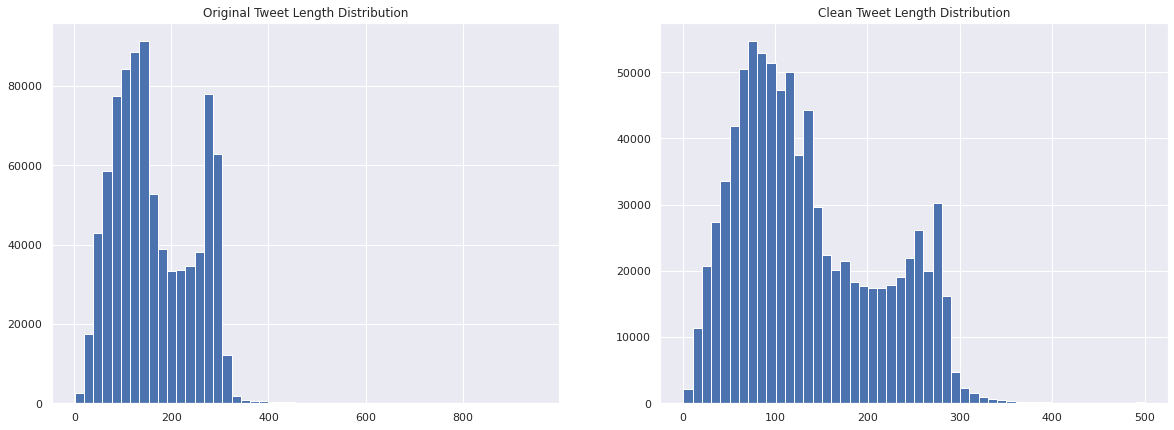

In [10]:
fig, ax = plt.subplots(1, 2, figsize=(20, 7))

ax[0].hist(tweet_lens, bins=50)
ax[0].set_title('Original Tweet Length Distribution')

# truncate the max length to 500 so we don't see as long of a tail
# for the clean tweets
hist_lens = clean_tweet_lens.copy()
hist_lens[hist_lens > 500] = 500
ax[1].hist(hist_lens, bins=50)
ax[1].set_title('Clean Tweet Length Distribution')

plt.show()

In [11]:
data.loc[clean_tweet_lens > 500, :].head(10)

,id,author_id,created_at,text,clean_text
13781,1195764350553853955,14182218,2019-11-16 18:03:32,👇🏿👇🏿👇🏿👇🏿👇🏿👇🏿👇🏿👇🏿👇🏿👇🏿👇🏿\n👉🏿👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👇🏾👈🏿...,backhand_index_pointing_down_dark_skin_tone ...
38597,1151255515982376960,1469101279,2019-07-16 22:21:18,Stop focusing on price!\nGo read a book damnit...,Stop focusing on price! Go read a book damnit!...
38987,1100182524167241728,1469101279,2019-02-25 23:55:28,It👏🏽is👏🏽illegal👏🏽under👏🏽international👏🏽law👏🏽to...,It clapping_hands_medium_skin_tone is clapping...
58069,738087815406333952,94274445,2016-06-01 19:20:22,"In &lt; 10 years, 📱 replaced: #codecon \n\n📟 ☎...","In &lt; 10 years, mobile_phone replaced: co..."
92020,1152521868043280384,19651231,2019-07-20 10:13:20,Banks vs Libra. How are the banks going to res...,Banks vs Libra. How are the banks going to res...
93644,1044531234318290945,19651231,2018-09-25 10:17:07,Arguably THE most anticipated comeback in spor...,Arguably THE most anticipated comeback in spor...
94657,1002959822336217088,19651231,2018-06-02 17:07:10,📻📻📻 As the Visa issues continue tune into what...,radio radio radio As the Visa issues conti...
95797,942179796238438400,19651231,2017-12-16 23:49:02,"What do you think will happen in FinTech, Bank...","What do you think will happen in FinTech, Bank..."
98540,833420884081774593,19651231,2017-02-19 20:59:57,Like what we do? Let them know 👇🏼👇🏼👇🏼👇🏼👇🏼👇🏼👇🏼👇...,Like what we do? Let them know backhand_index...
105036,1128637452002807810,902926941413453824,2019-05-15 12:25:12,"You can cancel orders now. Trading, placing n...","You can cancel orders now. Trading, placing n..."


In [12]:
data.loc[clean_tweet_lens < 15, :].head(10)

,id,author_id,created_at,text,clean_text
178,1419411635211436034,14182218,2021-07-25 21:37:59,@zooko HUGE!,@user HUGE!
185,1419410914982326272,14182218,2021-07-25 21:35:08,Confirmed. https://t.co/1ysHECGLNf,Confirmed. http
263,1418006095080169472,14182218,2021-07-22 00:32:53,Brilliant. https://t.co/FMfuArhOXq,Brilliant. http
348,1417138232232271875,14182218,2021-07-19 15:04:18,Iconic https://t.co/UulpixMa2U,Iconic http
748,1411044565532901377,14182218,2021-07-02 19:30:15,A sleeper. https://t.co/Q8wSMJ8Yyu,A sleeper. http
1152,1406071039793283073,14182218,2021-06-19 02:07:14,well https://t.co/9UrVbfyIr4,well http
1190,1405987596572889088,14182218,2021-06-18 20:35:39,@zooko I love ZEC,@user I love ZEC
1322,1403040835608846341,14182218,2021-06-10 17:26:17,BREAKING https://t.co/D5CDPpCYQB,BREAKING http
1357,1402792519159762946,14182218,2021-06-10 00:59:33,@zooko Same https://t.co/7Rpp618eHd,@user Same http
1379,1402763789917954055,14182218,2021-06-09 23:05:24,@zooko Same https://t.co/T8OemYQOLC,@user Same http


In [13]:
# drop clean tweets of length >500
# these are tweets with LOTS of emojis
# when translating emojis to text, the size of the tweets grows significantly
# also drop clean tweets of length <15 (counting [HANDLE] and [LINK] as one character)
# these are mostly one word tweets or tweets that are just a link
# see above for some examples
drop_idx = data.index[(clean_tweet_lens > 500) | (clean_tweet_lens < 15)]
data.drop(drop_idx, axis=0, inplace=True)

print('Remaining Tweets: {}'.format(data.shape[0]))

Remaining Tweets: 847540


We decide to drop the approximately five thousand very long and very short tweets as there are relatively few of these and it removes some of the noise in the data. We plot the final number of cleaned tweets per day and authors per day in the Top 100 dataset.

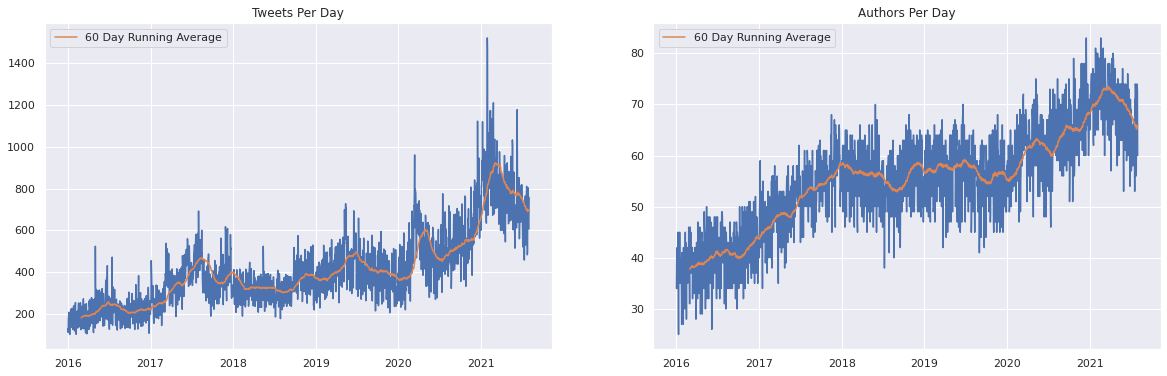

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20, 6))

tweets_per_day = data.groupby(pd.Grouper(key='created_at', freq='D'))['id'].count()
authors_per_day = data.groupby(pd.Grouper(key='created_at', freq='D'))['author_id'].nunique()

window = 60

ax[0].plot(tweets_per_day)
ax[1].plot(authors_per_day)

ax[0].plot(tweets_per_day.rolling(window).mean(), label='{} Day Running Average'.format(window))
ax[1].plot(authors_per_day.rolling(window).mean(), label='{} Day Running Average'.format(window))
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')

ax[0].set_title('Tweets Per Day')
ax[1].set_title('Authors Per Day')

plt.show()

Finally, we do one last check of the data and save the dataset with the cleaned tweets.

In [15]:
print('Days with 0 tweets: {}'.format(tweets_per_day.resample('D').asfreq().isna().sum()))

Days with 0 tweets: 0


In [16]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847540 entries, 0 to 853391
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id          847540 non-null  object        
 1   author_id   847540 non-null  object        
 2   created_at  847540 non-null  datetime64[ns]
 3   text        847540 non-null  object        
 4   clean_text  847540 non-null  object        
dtypes: datetime64[ns](1), object(4)
memory usage: 38.8+ MB


In [17]:
data.head()

,id,author_id,created_at,text,clean_text
0,1421578024630333443,14182218,2021-07-31 21:06:27,The whole thread is very much worth a read (an...,The whole thread is very much worth a read (an...
1,1421255297427984384,14182218,2021-07-30 23:44:03,@NeerajKA @crypt0e I don’t know if malicious i...,"@user I don’t know if malicious is the word, ..."
2,1421254480260222979,14182218,2021-07-30 23:40:48,@zooko comes online and my feed is all about @...,@user comes online and my feed is all about ...
3,1421248686332518406,14182218,2021-07-30 23:17:47,Social media influencers can use Zemo as a pro...,Social media influencers can use Zemo as a pro...
4,1421248527808843777,14182218,2021-07-30 23:17:09,Desired @zemoapp feature for spam handling:\nS...,Desired @user feature for spam handling: Set...


In [18]:
# drop the original text column 
# \r and \n in the text cause a lot of problems when saving 
# the data to csv
original_text = data['text']  # save original text for word cloud below
data.drop(['text'], axis=1, inplace=True)

In [19]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 847540 entries, 0 to 853391
Data columns (total 4 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   id          847540 non-null  object        
 1   author_id   847540 non-null  object        
 2   created_at  847540 non-null  datetime64[ns]
 3   clean_text  847540 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 32.3+ MB


In [20]:
data.to_csv(os.path.join(OUTPUT_DIR, 'twitter_dataset_top100.csv'), 
            index=False, encoding='utf-8')

In this next section, we create a word cloud for the Random Tweet dataset that helps us visualize the contents of the data by presenting the most frequently occuring words. The final image generated is included in the report. Note that the placement of words varies from run to tun for some reason (haven't looked into why), but the size of each word is consistent.

In [21]:
def decontracted(phrase):
    """
    Un-do contractions. For example, "won't" becomes "will not",
    "he's" becomes "he is", etc. There are some issues as 
    "Tom's" becomes "Tom is" even though this is a possessive 
    noun, but this isn't an issue for purposes of the word cloud.
    """
    # from https://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python
    # biggest issue is possessive nouns

    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)

    return phrase

def word_cloud_counts(texts):
    """Create the word frequency dict used to generate the word cloud."""
    word_counts = defaultdict(lambda: 0)
    
    for text in texts:
        # twitter parsing 
        # we replace emojis with text as the wordcloud library 
        # requires additional code/dependencies to use plot emojis
        text = clean_text(text)
        
        # basic text parsing
        text = text.lower()
        text = decontracted(text)
        text = re.sub(r'[^0-9a-z\s]+', ' ', text)

        # tokenize each word
        word_list = re.findall('(?u)\\b\\w\\w+\\b', text)
        # remove stop words
        word_list = [word for word in word_list if word not in STOP_WORDS]

        for word in word_list:
            word_counts[word] += 1

    return word_counts

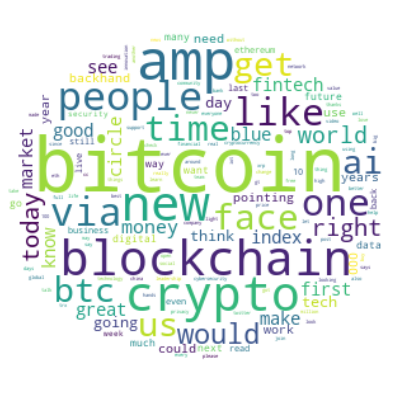

In [22]:
fig, ax = plt.subplots(1, 1, figsize=(10, 7))

word_counts = word_cloud_counts(original_text)
# link and handle are tokens added in the Twitter parsing
word_counts.pop('user')
word_counts.pop('http')

# ellipse shape
x, y = np.ogrid[:300, :300]
mask = (x - 150) ** 2 + (y - 150) ** 2 / 1.2 ** 2 > 130 ** 2
mask = 255 * mask.astype(int)

wc = WordCloud(background_color='white', mask=mask)
wc.generate_from_frequencies(word_counts)

plt.imshow(wc, interpolation='bilinear')
plt.axis('off')

# save for the report
fig.savefig('word_cloud_100.png')
plt.show()